# Multiobjective optimization for sizing problem

The goal is to implement multi-objective optimization problem.

In [1]:
import array
import numpy as np
from deap import base, creator, tools, algorithms, benchmarks
import matplotlib.pyplot as plt
%matplotlib inline

Najprv si zadefinujeme nejaké parametre potrebné pre zbehnutie evolučnej stratégie. Parametrami je veľkosť jedinca, minimálna stratégia (nech to znamená hocičo), maximálna stratégia a nejaké naivne vytvorené dáta o spotrebe.

In [2]:
IND_SIZE = 25
MIN_STRATEGY = 0.5
MAX_STRATEGY = 3
demands = np.array([10,10,10,20,30,50,100,240,200,100,10,10,20,30,20,50,150,100,200,150,140,150,90,10])

Teraz si zadefinujeme stratové funkcie.
- Prvá bude _Loss of power supply probability_,
- druhá bude suma percent aktuálnych výkonov v čase $t$.

In [3]:
def de(generated, demanded):
    diff = generated - demanded
    diff[diff > 0] = 0
    return np.abs(diff)

# x[0] je maximálny výkon generátora
# x[1:25] je aktuálny výkon
def cost_function(x):
    objective1 = sum(de(x[0]*np.array(x[1:]), demands))/sum(demands)
    objective2 = sum(x[1:])
    return (objective1, objective2)

Nasledujúce funkcie sú potrebné pre algoritmus evolučnej stratégie. V druhej funkcií `generateES` sa vlasne vygeneruje jedinec, aj s príslušnými stratégiami.

In [4]:
def create_individual():
    generator_max = np.random.randint(100,300)
    floats = np.random.uniform(0.5, 0.9, 24).tolist()
    return [generator_max, *floats]

def generateES(icls, scls, size, smin, smax):
    ind = icls(create_individual())
    ind.strategy = scls(np.random.uniform(smin, smax) for _ in range(size))
    return ind

In [5]:
creator.create('FitnessMulti', base.Fitness, weights=(-1.0, -1.0))
creator.create('Individual', array.array, typecode='d', fitness=creator.FitnessMulti, strategy=None)
creator.create('Strategy', array.array, typecode='d')

Tu si zaregistrujeme potrebné funkcie pre úspešné zbehnutie algoritmu. Jednak teda vytvorenie jedinca a populácie a operátory pre evolučnú stratégiu.

V prípade registrovania funkcie `individual` argumenty fungujú nasledujúcim spôsobom: druhý argument je vlastne funkcia (`generateES`), ktorá sa zavollá vždy keď sa ide nejaký jedinec generovať, všetky ostatné argumenty sú vlastne argumenty, ktoré sa nasypú do `generateES`. 

In [23]:
toolbox = base.Toolbox()

toolbox.register('individual', generateES, creator.Individual, creator.Strategy,
                IND_SIZE, MIN_STRATEGY, MAX_STRATEGY)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# operators
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=3)


Čo robí tento dekorátor som ešte nezistil.

In [16]:
def checkStrategy(minstrategy):
    def decorator(func):
        def wrappper(*args, **kargs):
            children = func(*args, **kargs)
            for child in children:
                for i, s in enumerate(child.strategy):
                    if s < minstrategy:
                        child.strategy[i] = minstrategy
            return children
        return wrappper
    return decorator

In [17]:
toolbox.decorate("mate", checkStrategy(MIN_STRATEGY))
toolbox.decorate("mutate", checkStrategy(MIN_STRATEGY))

Teraz ešte pridáme obmedzenia pre náš problém. Ako aj uviedli autori dokumentácie, evolučné algoritmy sú typické skôr pre neohraničené optimalizačné problémy, ale existujú nejaké metódy, ako evolučný algoritmus prispôsobiť tak, aby bral do úvahy aj obmedzenia.

Jeden z takých spôsobov je hrubo penalizovať každého jedinca, ktorý sa vyskytne mimo prípustnej oblasti. Spôsobov penalizácie je [tiež niekoľko](http://deap.readthedocs.io/en/master/tutorials/advanced/constraints.html#penalty-function).

In [70]:
def feasible(x):
    if x[0] < 50 or x[0] > 300:
        return False
    power_levels = np.array(x[1:])
    if (power_levels < 0.5).any():
        return False
    if (power_levels > 1).any():
        return False
    
    return True

def distance(individual):
    return 10000000

toolbox.register("evaluate", cost_function)
toolbox.decorate('evaluate', tools.DeltaPenalty(feasible, 7000000.0, distance))

In [71]:
np.random.seed()

In [76]:
MU, LAMBDA = 10, 100
pop = toolbox.population(n=30)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [77]:
pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=10, lambda_=100,
                                          cxpb=0.6, mutpb=0.3, ngen=500,
                                          halloffame=hof)

gen	nevals
0  	30    
1  	89    
2  	88    
3  	88    
4  	92    
5  	92    
6  	89    
7  	89    
8  	91    
9  	93    
10 	85    
11 	91    
12 	90    
13 	93    
14 	92    
15 	88    
16 	96    
17 	83    
18 	86    
19 	87    
20 	89    
21 	87    
22 	90    
23 	88    
24 	88    
25 	84    
26 	92    
27 	92    
28 	90    
29 	89    
30 	89    
31 	96    
32 	91    
33 	90    
34 	91    
35 	93    
36 	92    
37 	89    
38 	85    
39 	86    
40 	91    
41 	88    
42 	88    
43 	93    
44 	90    
45 	91    
46 	94    
47 	85    
48 	90    
49 	93    
50 	92    
51 	94    
52 	90    
53 	93    
54 	96    
55 	91    
56 	91    
57 	87    
58 	84    
59 	94    
60 	90    
61 	96    
62 	89    
63 	89    
64 	91    
65 	95    
66 	89    
67 	89    
68 	91    
69 	79    
70 	94    
71 	92    
72 	87    
73 	90    
74 	92    
75 	91    
76 	90    
77 	91    
78 	94    
79 	94    
80 	92    
81 	92    
82 	89    
83 	89    
84 	89    
85 	90    
86 	85    
87 	92    
88 	92    
89 	89    

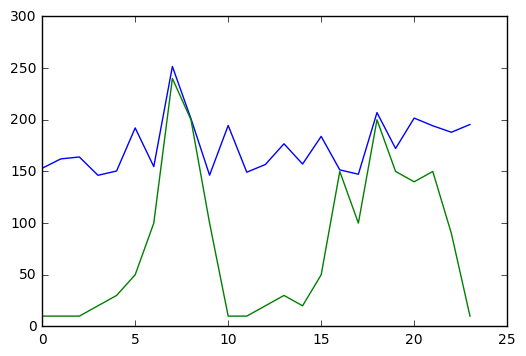

In [78]:
fig, ax = plt.subplots(1,1)
ax.plot(hof[0][0] * np.array(hof[0][1:]))
ax.plot(demands)

In [75]:
hof[0]

array('d', [258.7403765015759, 0.6184662013316744, 0.5329160435565886, 0.6506273266896042, 0.5397244365191901, 0.657411459183534, 0.5597070893581142, 0.5999918192017979, 0.9318765248401308, 0.8382285448398308, 0.5451862513120026, 0.5971127045305478, 0.7222455319338337, 0.7727861505646851, 0.598746021434487, 0.5154993119904338, 0.7074192664065616, 0.6323321821043624, 0.6600115867622345, 0.9872589620936152, 0.6715973789246426, 0.5880278241954366, 0.6520114115468869, 0.6030974214128035, 0.5926100562132164])